In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, max as spark_max, countDistinct, sum as spark_sum, datediff, lit, when
from dotenv import load_dotenv
import pandas as pd
import os

# Load environment variables from .env
load_dotenv()

# Initialize Spark session
spark = SparkSession.builder \
    .appName("CustomerJourneyAnalysis") \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-azure:3.3.1") \
    .config("fs.azure.account.key.dataintensiveproject.blob.core.windows.net", os.getenv("AZURE_STORAGE_KEY")) \
    .getOrCreate()


Python-dotenv could not parse statement starting at line 2
Python-dotenv could not parse statement starting at line 3
Python-dotenv could not parse statement starting at line 4
25/04/21 20:08:12 WARN Utils: Your hostname, Rishabhs-Laptop.local resolves to a loopback address: 127.0.0.1; using 192.168.0.179 instead (on interface en0)
25/04/21 20:08:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/rishabhsaudagar/.ivy2/cache
The jars for the packages stored in: /Users/rishabhsaudagar/.ivy2/jars
org.apache.hadoop#hadoop-azure added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-a0dc8dc0-e160-4b19-ab17-aecdddf7f319;1.0
	confs: [default]


:: loading settings :: url = jar:file:/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.apache.hadoop#hadoop-azure;3.3.1 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.11 in central
	found com.microsoft.azure#azure-storage;7.0.1 in central
	found com.fasterxml.jackson.core#jackson-core;2.10.5 in central
	found org.slf4j#slf4j-api;1.7.30 in central
	found com.microsoft.azure#azure-keyvault-core;1.0.0 in central
	found com.google.guava#guava;27.0-jre in central
	found com.google.guava#failureaccess;1.0 in central
	found com.google.guava#listenablefuture;9999.0-empty-to-avoid-conflict-with-guava in central
	found com.google.code.findbugs#jsr305;3.0.2 in central
	found org.checkerframework#checker-qual;2.5.2 in central
	found com.google.errorprone#error_prone_annotations;2.2.0 in central
	found com.google.j2objc#j2objc-annotations;1.1 in central
	found org.codehaus.mojo#animal-sniffer-anno

In [2]:
# Path to your Parquet data
parquet_path = "wasbs://retail-data@dataintensiveproject.blob.core.windows.net/clean/retail_cleaned"

# Read the cleaned data
df = spark.read.parquet(parquet_path)
df.printSchema()
df.show(5)


25/04/21 20:08:17 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-azure-file-system.properties,hadoop-metrics2.properties


root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp_ntz (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- InvoiceYear: integer (nullable = true)
 |-- InvoiceMonth: integer (nullable = true)
 |-- InvoiceWeekday: integer (nullable = true)
 |-- InvoiceHour: integer (nullable = true)



+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-----------+------------+--------------+-----------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|InvoiceYear|InvoiceMonth|InvoiceWeekday|InvoiceHour|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-----------+------------+--------------+-----------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|       2010|          12|             4|          8|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|       2010|          12|             4|          8|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|       2010|          12|             4|          8|
|   536365|   84029G|KNITTED UNION FLA..

In [3]:
monthly_sales = df.groupBy("InvoiceYear", "InvoiceMonth") \
    .agg(spark_sum(col("Quantity") * col("UnitPrice")).alias("TotalSales")) \
    .orderBy("InvoiceYear", "InvoiceMonth")

monthly_sales.show(12)

+-----------+------------+------------------+
|InvoiceYear|InvoiceMonth|        TotalSales|
+-----------+------------+------------------+
|       2010|          12| 572713.8900000163|
|       2011|           1| 569445.0400000077|
|       2011|           2| 447137.3500000165|
|       2011|           3|  595500.760000013|
|       2011|           4| 469200.3610000132|
|       2011|           5| 678594.5600000018|
|       2011|           6| 661213.6900000116|
|       2011|           7| 600091.0110000141|
|       2011|           8|  645343.900000009|
|       2011|           9| 952838.3819999964|
|       2011|          10|1039318.7899999822|
|       2011|          11|1161817.3799999433|
+-----------+------------+------------------+
only showing top 12 rows



In [4]:
monthly_sales_pd = monthly_sales.toPandas()
monthly_sales_pd["Month"] = pd.to_datetime(
    monthly_sales_pd["InvoiceYear"].astype(str) + "-" + monthly_sales_pd["InvoiceMonth"].astype(str), format="%Y-%m"
)
monthly_sales_pd = monthly_sales_pd.sort_values("Month")


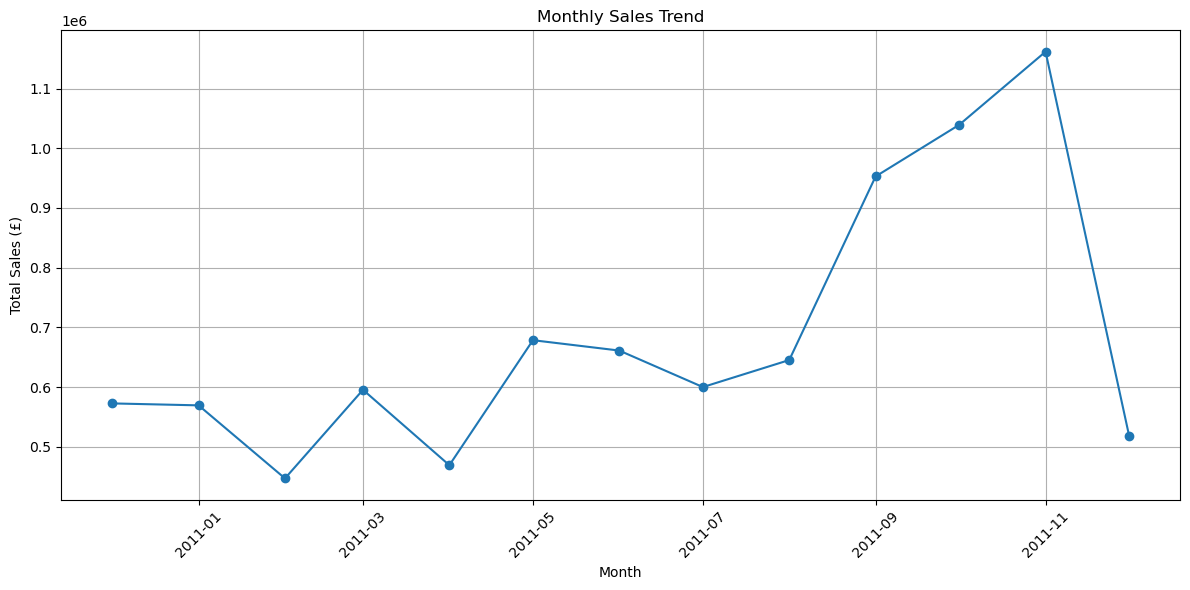

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_pd["Month"], monthly_sales_pd["TotalSales"], marker='o')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales (£)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# Sort to find top and bottom months
top_months = monthly_sales_pd.sort_values("TotalSales", ascending=False).head(3)
bottom_months = monthly_sales_pd.sort_values("TotalSales", ascending=True).head(3)

print("📈 Top Performing Months:\n", top_months)
print("\n📉 Lowest Performing Months:\n", bottom_months)

📈 Top Performing Months:
     InvoiceYear  InvoiceMonth   TotalSales      Month
11         2011            11  1161817.380 2011-11-01
10         2011            10  1039318.790 2011-10-01
9          2011             9   952838.382 2011-09-01

📉 Lowest Performing Months:
     InvoiceYear  InvoiceMonth  TotalSales      Month
2          2011             2  447137.350 2011-02-01
4          2011             4  469200.361 2011-04-01
12         2011            12  518192.790 2011-12-01


In [7]:
monthly_sales_pd["MonthName"] = monthly_sales_pd["Month"].dt.strftime("%b %Y")

ValueError: x must have 2 complete cycles requires 24 observations. x only has 13 observation(s)

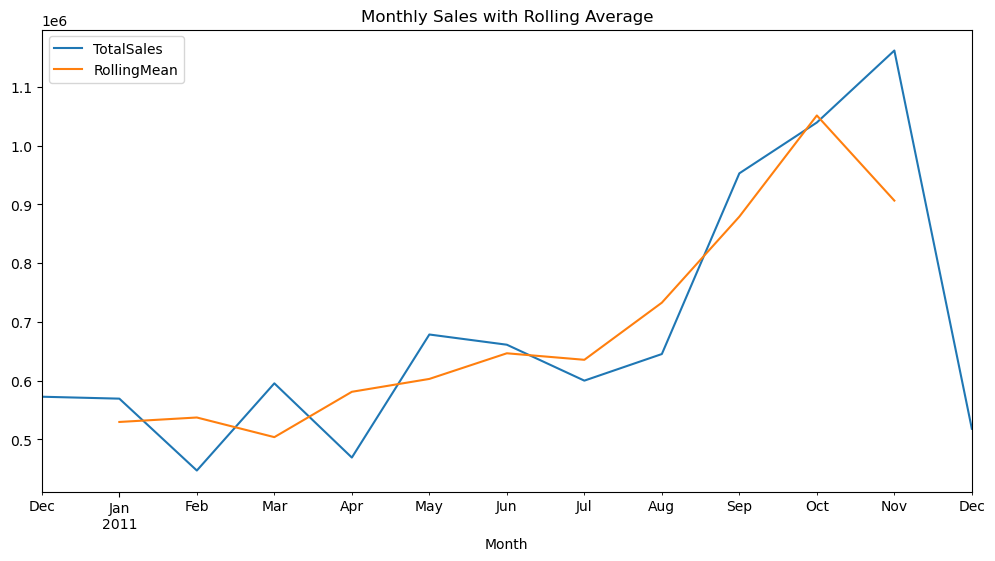

In [11]:
!pip install statsmodels

from statsmodels.tsa.seasonal import seasonal_decompose

# Set Month as index for time series
monthly_sales_pd["RollingMean"] = monthly_sales_pd["TotalSales"].rolling(window=3, center=True).mean()

monthly_sales_pd[["TotalSales", "RollingMean"]].plot(figsize=(12, 6), title="Monthly Sales with Rolling Average")


result = seasonal_decompose(monthly_sales_pd["TotalSales"], model="additive")

# Plot decomposition
result.plot()
plt.tight_layout()
plt.show()

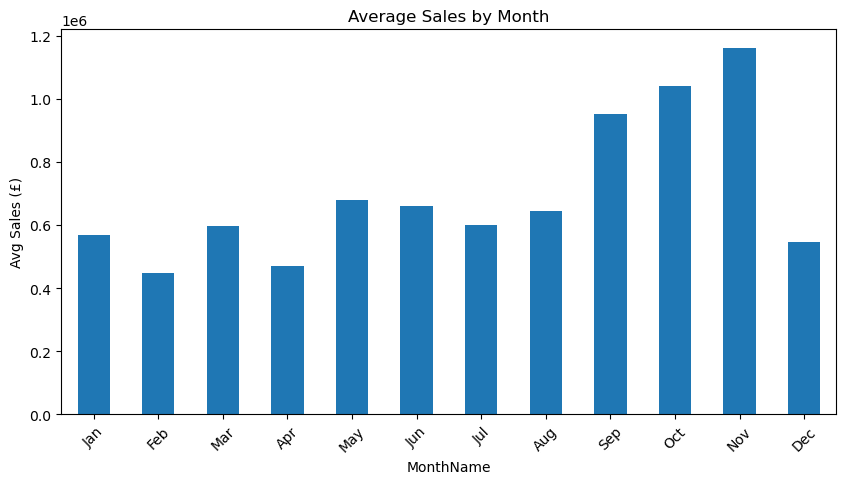

In [12]:
import matplotlib.pyplot as plt

# Extract month names and calculate average sales
monthly_avg = monthly_sales_pd.copy()
monthly_avg['MonthName'] = monthly_avg.index.strftime('%b')
monthly_avg = monthly_avg.groupby("MonthName")["TotalSales"].mean().reindex([
    'Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

# Plot bar chart
monthly_avg.plot(kind='bar', figsize=(10, 5), title='Average Sales by Month', ylabel='Avg Sales (£)')
plt.xticks(rotation=45)
plt.show()


In [14]:
from pyspark.sql.functions import col

# Ensure TotalPrice is numeric
df = df.withColumn("TotalPrice", col("UnitPrice") * col("Quantity"))
df = df.withColumn("TotalPrice", col("TotalPrice").cast("double"))

In [16]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp_ntz (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- InvoiceYear: integer (nullable = true)
 |-- InvoiceMonth: integer (nullable = true)
 |-- InvoiceWeekday: integer (nullable = true)
 |-- InvoiceHour: integer (nullable = true)
 |-- TotalPrice: double (nullable = true)



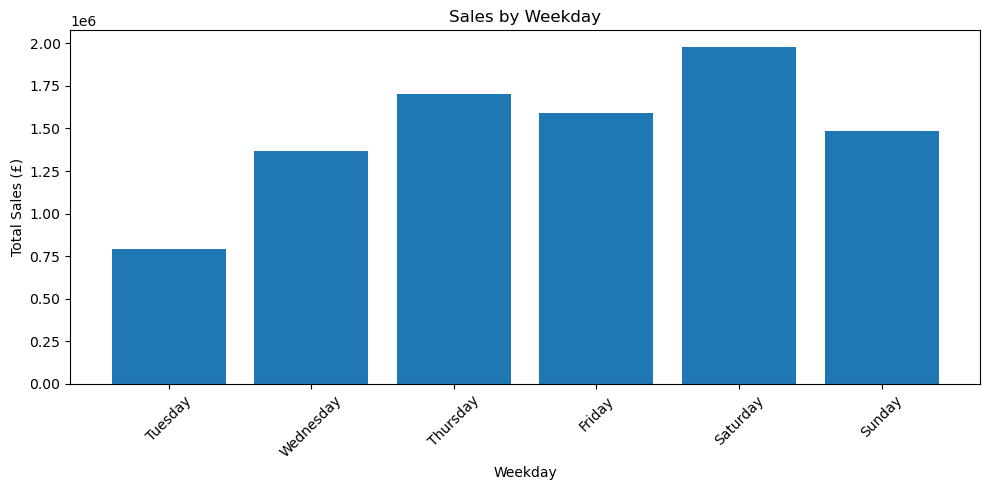

In [17]:
from pyspark.sql.functions import sum as _sum

# Group by weekday
weekday_sales = df.groupBy("InvoiceWeekday").agg(_sum("TotalPrice").alias("WeekdaySales")) \
                  .orderBy("InvoiceWeekday")

# Convert to pandas for plotting
weekday_sales_pd = weekday_sales.toPandas()

# Replace numbers with weekday names (optional for readability)
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales_pd["InvoiceWeekday"] = weekday_sales_pd["InvoiceWeekday"].astype(int)
weekday_sales_pd["WeekdayName"] = weekday_sales_pd["InvoiceWeekday"].apply(lambda x: weekday_names[x])

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(weekday_sales_pd["WeekdayName"], weekday_sales_pd["WeekdaySales"])
plt.title("Sales by Weekday")
plt.ylabel("Total Sales (£)")
plt.xlabel("Weekday")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
# Seasonality
df.coalesce(1).write.mode('overwrite').option("header", True).csv("PowerBI/monthly_trends")

25/04/22 03:53:04 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1971762 ms exceeds timeout 120000 ms
25/04/22 03:53:04 WARN SparkContext: Killing executors is not supported by current scheduler.
25/04/22 03:53:05 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at s